In [1]:
# Packages
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

pd.set_option('display.max_rows', 10)

# mlflow
import mlflow
from mlflow.models import infer_signature
import mlflow.sklearn

mlflow.set_tracking_uri("http://localhost:5000")
#import logging

#logging.basicConfig(level=logging.WARN)
#logger = logging.getLogger(__name__)


In [2]:
# export processed data set to csv

# export features for tree-based models
X_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_all.csv')
X_test_dogs =pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_all.csv')


# export target
y_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv')
y_test_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv')


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4016
_____________________
Weighted Quadratic Kappa: 0.2991


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported 

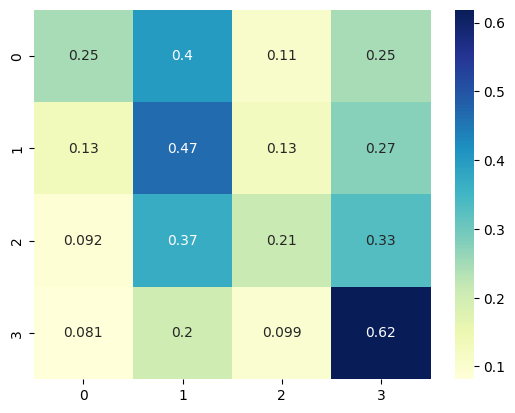

In [30]:
#mlflow.start_run()

with mlflow.start_run(run_name="Dogs_only_ada_boost_default"):
    ada1 = AdaBoostClassifier(random_state=42)
    ada1.fit(X_train_dogs, y_train_dogs)

    y_pred_ada1 = ada1.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_ada1, normalize=True) # 0.3758 0.2666

    # Infer model signature
    signature = infer_signature(X_test_dogs, y_pred_ada1)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_ada1))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_ada1,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = ada1,artifact_path="art", signature=signature,registered_model_name="Default_ada_boost_dogs_only")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "ada_boost")
    mlflow.set_tag("params", "default")
    mlflow.set_tag("quantity", "dropped")





In [ ]:
with mlflow.start_run(run_name="Dogs_only_ada_boost_random_search"):

    ada_classifier = AdaBoostClassifier(random_state=42)
    param_grid = {
        'n_estimators': [3,5,15,25,50,75,100],
        'learning_rate': [0.01,0.1,0.25,0.5,1,1.5,2,5],
        'algorithm': ["SAMME.R","SAMME]"]
    }

    random_search_acc = RandomizedSearchCV(ada_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=500,random_state=42)

    random_search_acc.fit(X_train_dogs, y_train_dogs)

    y_pred_rc = random_search_acc.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_rc, normalize=True)

    signature = infer_signature(X_test_dogs, y_pred_rc)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = random_search_acc,artifact_path="art", signature=signature,registered_model_name="random_search_adaboost_dogs")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "ada_boost")
    mlflow.set_tag("params", "random_search")
    mlflow.set_tag("rs_metric", "accuracy")


In [26]:
random_search_acc.best_params_
random_search_acc.best_score_

0.4013769684907006

/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 80 is smaller than n_iter=1500. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.ve

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3961
_____________________
Weighted Quadratic Kappa: 0.3245


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported 

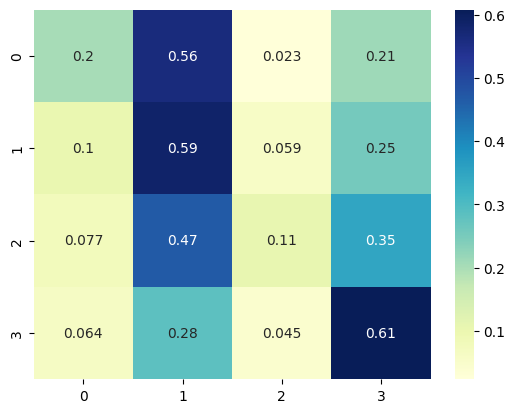

In [32]:
with mlflow.start_run(run_name="Dogs_only_ada_boost_random_search_kappa"):

    ada_classifier = AdaBoostClassifier(random_state=42)
    param_grid = {
        'n_estimators': [15,25,50,75,100],
        'learning_rate': [0.01,0.1,0.25,0.5,1,1.5,2,5],
        'algorithm': ["SAMME.R","SAMME]"]
    }
    kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

    random_search_kap = RandomizedSearchCV(ada_classifier, param_grid, scoring=kappa_scorer, cv=5, n_jobs=-1,n_iter=1500,random_state=42)

    random_search_kap.fit(X_train_dogs, y_train_dogs)

    y_pred_rc = random_search_kap.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_rc, normalize=True)

    signature = infer_signature(X_test_dogs, y_pred_rc)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = random_search_kap,artifact_path="art", signature=signature,registered_model_name="random_search_adaboost_dogs_kappa")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "ada_boost")
    mlflow.set_tag("params", "random_search")
    mlflow.set_tag("rs_metric", "kappa")


# HistGradient

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier

/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3931
_____________________
Weighted Quadratic Kappa: 0.3081


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported 

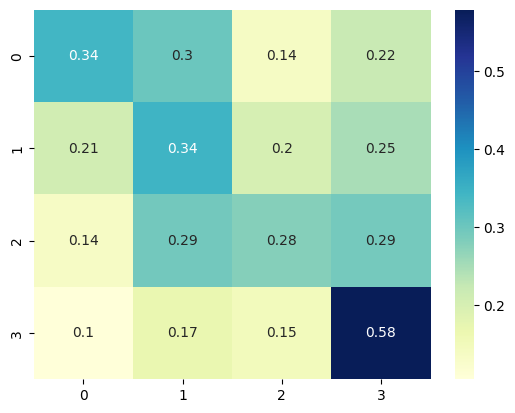

In [34]:
#mlflow.start_run()

with mlflow.start_run(run_name="Dogs_only_hist_boost_default"):
    hist1 = HistGradientBoostingClassifier(random_state=42)
    hist1.fit(X_train_dogs, y_train_dogs)

    y_pred_ada1 = hist1.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_ada1, normalize=True) # 0.3758 0.2666

    # Infer model signature
    signature = infer_signature(X_test_dogs, y_pred_ada1)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_ada1))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_ada1,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = hist1,artifact_path="art", signature=signature,registered_model_name="Default_hist_boost_dogs_only")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "histgradientboost")
    mlflow.set_tag("params", "default")
    mlflow.set_tag("quantity", "dropped")





/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_caps

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.413
_____________________
Weighted Quadratic Kappa: 0.3282


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'random_search_histboost_dogs'.
2023/08/29 20:42:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: random_search_histb

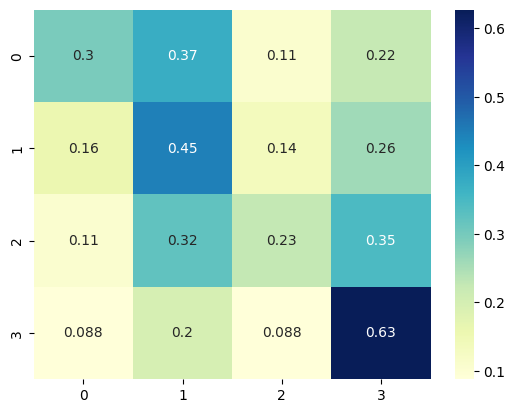

In [36]:
with mlflow.start_run(run_name="Dogs_only_hist_boost_random_search"):

    hist_classifier = HistGradientBoostingClassifier(random_state=42)
    param_grid = {
        'max_iter': [3,5,15,25,50,75,100,150],
        'learning_rate': [0.01,0.1,0.25,0.5,1],
        'max_leaf_nodes': [1,3,5,7,10,15,25,31,42],
        'max_depth': [1,2,3,5,7,9,10,15,20,None],
        'l2_regularization': [0,0.25,0.5,0.75,1],
        'interaction_cst': ['pairwise', 'no_interactions']
    }

    random_search_hist_acc = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=500,random_state=42)

    random_search_hist_acc.fit(X_train_dogs, y_train_dogs)

    y_pred_rc = random_search_hist_acc.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_rc, normalize=True)

    signature = infer_signature(X_test_dogs, y_pred_rc)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = random_search_hist_acc,artifact_path="art", signature=signature,registered_model_name="random_search_histboost_dogs")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "hist boost")
    mlflow.set_tag("params", "random_search")
    mlflow.set_tag("rs_metric", "accuracy")


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_caps

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4118
_____________________
Weighted Quadratic Kappa: 0.3455


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported 

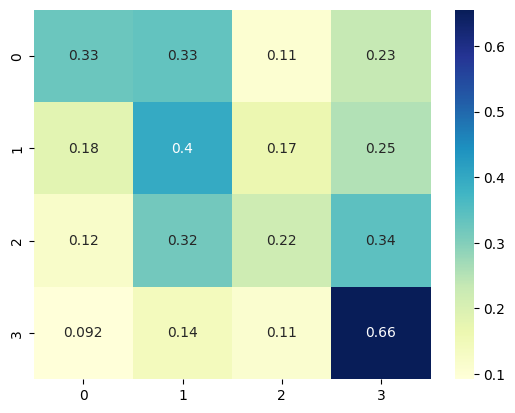

In [37]:
with mlflow.start_run(run_name="Dogs_only_hist_boost_random_search_kappa"):

    hist_classifier = HistGradientBoostingClassifier(random_state=42)
    param_grid = {
        'max_iter': [3,5,15,25,50,75,100,150],
        'learning_rate': [0.01,0.1,0.25,0.5,1],
        'max_leaf_nodes': [1,3,5,7,10,15,25,31,42],
        'max_depth': [1,2,3,5,7,9,10,15,20,None],
        'l2_regularization': [0,0.25,0.5,0.75,1],
        'interaction_cst': ['pairwise', 'no_interactions']
    }

    kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

    random_search_hist_acc = RandomizedSearchCV(hist_classifier, param_grid, scoring=kappa_scorer, cv=5, n_jobs=-1,n_iter=500,random_state=42)

    random_search_hist_acc.fit(X_train_dogs, y_train_dogs)

    y_pred_rc = random_search_hist_acc.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_rc, normalize=True)

    signature = infer_signature(X_test_dogs, y_pred_rc)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = random_search_hist_acc,artifact_path="art", signature=signature,registered_model_name="random_search_histboost_dogs")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "hist boost")
    mlflow.set_tag("params", "random_search")
    mlflow.set_tag("rs_metric", "accuracy")


# XGBoost

In [1]:
#pip install xgboost

In [2]:
import xgboost as xgb

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3931
_____________________
Weighted Quadratic Kappa: 0.304


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
Successfully registered model 'Default_xg_boost_dogs_only'.
2023/08/29 20:59:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model vers

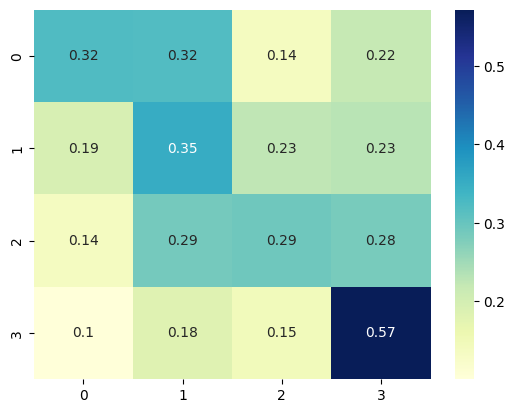

In [10]:
#mlflow.start_run()

with mlflow.start_run(run_name="Dogs_only_xgboost_default"):
    xg1 = xgb.XGBClassifier(objective="multi:softprob",random_state=42)
    xg1.fit(X_train_dogs, y_train_dogs-1)

    y_pred_xgb1 = xg1.predict(X_test_dogs)
    our_metrics(y_test_dogs-1, y_pred_xgb1, normalize=True) # 0.3758 0.2666

    # Infer model signature
    signature = infer_signature(X_test_dogs, y_pred_xgb1-1)

    # Log parameter, metrics, and model to MLflow
    #mlflow.log_param("alpha", alpha)
    #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs-1,y_pred_xgb1))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs-1,y_pred_xgb1,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = xg1,artifact_path="art", signature=signature,registered_model_name="Default_xg_boost_dogs_only")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "xg")
    mlflow.set_tag("params", "default")
    mlflow.set_tag("quantity", "dropped")





In [24]:
from sklearn.ensemble import GradientBoostingClassifier    

/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adopta

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4173
_____________________
Weighted Quadratic Kappa: 0.3469


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported 

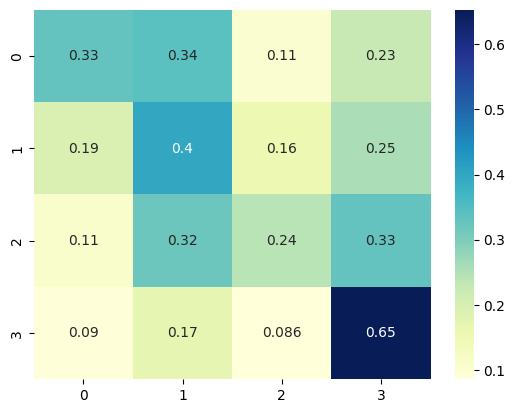

In [30]:
with mlflow.start_run(run_name = "GradientBoost_gridsearch_accu_dogs_only"):

    hist_classifier = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'loss': ["log_loss", "exponential"],
        #'max_iter': [3,5,15,25,50,75,100,150],
        'learning_rate': [0.01,0.1,0.25,0.5,1],
        'max_leaf_nodes': [1,3,5,7,10,15,25,31,42],
        'max_depth': [1,2,3,5,7,9,10,15,20,None],
        #'l2_regularization': [0,0.25,0.5,0.75,1],
        'max_features': ['sqrt', 'log2'],
        'subsample': [0.1,0.5,1]
        }

    #kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

    random_search_hist_acc = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=500,random_state=42)

    random_search_hist_acc.fit(X_train_dogs, y_train_dogs)

    y_pred_rc = random_search_hist_acc.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_rc, normalize=True)

    signature = infer_signature(X_test_dogs, y_pred_rc)

    # Log parameter, metrics, and model to MLflow
    # #mlflow.log_param("alpha", alpha)
    # #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = random_search_hist_acc,artifact_path="art", signature=signature,registered_model_name="random_search_gradboost_dogs_accu")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "gradient boost")
    mlflow.set_tag("params", "random_search")
    mlflow.set_tag("rs_metric", "accu")


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adopta

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4173
_____________________
Weighted Quadratic Kappa: 0.3469


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported 

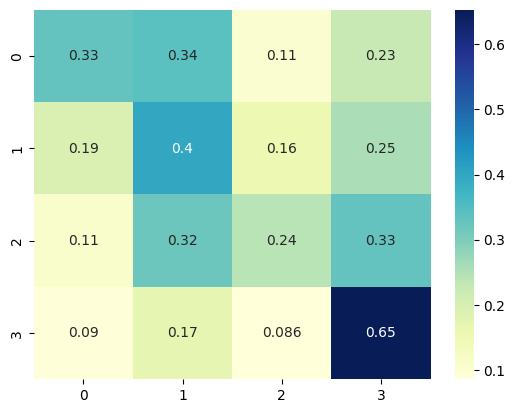

In [29]:
with mlflow.start_run(run_name = "GradientBoost_gridsearch_kappa_dogs_only"):

    hist_classifier = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'loss': ["log_loss", "exponential"],
        #'max_iter': [3,5,15,25,50,75,100,150],
        'learning_rate': [0.01,0.1,0.25,0.5,1],
        'max_leaf_nodes': [1,3,5,7,10,15,25,31,42],
        'max_depth': [1,2,3,5,7,9,10,15,20,None],
        #'l2_regularization': [0,0.25,0.5,0.75,1],
        'max_features': ['sqrt', 'log2'],
        'subsample': [0.1,0.5,1]
        }

    kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

    random_search_hist_kap = RandomizedSearchCV(hist_classifier, param_grid, scoring=kappa_scorer, cv=5, n_jobs=-1,n_iter=500,random_state=42)

    random_search_hist_kap.fit(X_train_dogs, y_train_dogs)

    y_pred_rc = random_search_hist_kap.predict(X_test_dogs)
    our_metrics(y_test_dogs, y_pred_rc, normalize=True)

    signature = infer_signature(X_test_dogs, y_pred_rc)

    # Log parameter, metrics, and model to MLflow
    # #mlflow.log_param("alpha", alpha)
    # #mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
    mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


    mlflow.sklearn.log_model(sk_model = random_search_hist_kap,artifact_path="art", signature=signature,registered_model_name="random_search_gradboost_dogs_kappa")
    mlflow.set_tag("data_source", "dogs")
    mlflow.set_tag("experiment_type", "gradient boost")
    mlflow.set_tag("params", "random_search")
    mlflow.set_tag("rs_metric", "kappa")


In [31]:
random_search_hist_acc.best_params_

{'subsample': 1,
 'max_leaf_nodes': 15,
 'max_features': 'sqrt',
 'max_depth': None,
 'loss': 'log_loss',
 'learning_rate': 0.1}

In [32]:
random_search_hist_kap.best_params_

{'subsample': 1,
 'max_leaf_nodes': 15,
 'max_features': 'sqrt',
 'max_depth': None,
 'loss': 'log_loss',
 'learning_rate': 0.1}

# Best:

In [99]:
random_search_hist_kap.best_params_

{'subsample': 0.9,
 'max_leaf_nodes': 10,
 'max_features': 'sqrt',
 'max_depth': 15,
 'loss': 'log_loss',
 'learning_rate': 0.1}

/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adopta

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4124
_____________________
Weighted Quadratic Kappa: 0.3293


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
Registered model 'tight_random_search_gradboost_dogs_kappa' already exists. Creating a new version of this model...
2023/08/31 21:00:28 INFO mlflow.tracking._model_r

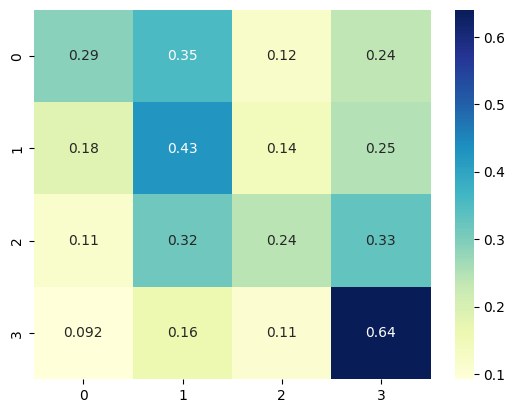

In [8]:
with mlflow.start_run(run_name = "Tight_GradientBoost_gridsearch_accu_dogs_only"):

        hist_classifier = GradientBoostingClassifier(random_state=42)
        param_grid = {
                'loss': ["log_loss", "exponential"],
                #'max_iter': [3,5,15,25,50,75,100,150],
                'learning_rate': [0.01,0.05,0.1,0.125,0.15,0.2],
                'max_leaf_nodes': [10,13,15,17,19],
                'max_depth': [15,20,None],
                #'l2_regularization': [0,0.25,0.5,0.75,1],
                'max_features': ['sqrt', 'log2'],
                'subsample': [0.8,0.9,1]
                }

        #kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

        random_search_hist_kap = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=500,random_state=42)

        random_search_hist_kap.fit(X_train_dogs, y_train_dogs)

        y_pred_rc = random_search_hist_kap.predict(X_test_dogs)
        our_metrics(y_test_dogs, y_pred_rc, normalize=True)

        signature = infer_signature(X_test_dogs, y_pred_rc)

    # # Log parameter, metrics, and model to MLflow
        mlflow.log_param("all", random_search_hist_kap.best_params_)
    # # #mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("acc", accuracy_score(y_test_dogs,y_pred_rc))
        mlflow.log_metric("kappa", cohen_kappa_score(y_test_dogs,y_pred_rc,weights="quadratic"))


        mlflow.sklearn.log_model(sk_model = random_search_hist_kap,artifact_path="art", signature=signature,registered_model_name="tight_random_search_gradboost_dogs_kappa")
        mlflow.set_tag("data_source", "dogs")
        mlflow.set_tag("experiment_type", "gradient boost")
        mlflow.set_tag("params", "tight_random_search")
        mlflow.set_tag("rs_metric", "accu")


# Make it 3 Class:

In [64]:
y_train_dogs = [x-1 if x >= 3 else x for x in y_train_dogs.adoptionspeed]
y_test_dogs = [x-1 if x >= 3 else x for x in y_test_dogs.adoptionspeed]


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1255 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1255 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 444, in fit
    self._check_params()
  File "/Users/janschla

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.5531
_____________________
Weighted Quadratic Kappa: 0.2867


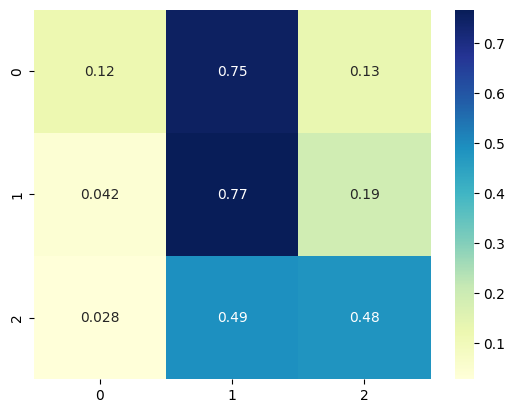

In [44]:
hist_classifier = GradientBoostingClassifier(random_state=42)
param_grid = {
                'loss': ["log_loss"],
                #'max_iter': [3,5,15,25,50,75,100,150],
                'learning_rate': [0.01,0.05,0.1,0.125,0.15,0.2],
                'max_leaf_nodes': [10,13,15,17,19],
                'max_depth': [15,20,None],
                #'l2_regularization': [0,0.25,0.5,0.75,1],
                'max_features': ['sqrt', 'log2'],
                'subsample': [0.8,0.9,1]
                }

        #kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

random_search_hist_kap = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=500,random_state=42)

random_search_hist_kap.fit(X_train_dogs, y_train_dogs)

y_pred_rc = random_search_hist_kap.predict(X_test_dogs)
our_metrics(y_test_dogs, y_pred_rc, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.6297
_____________________
Weighted Quadratic Kappa: 0.4001


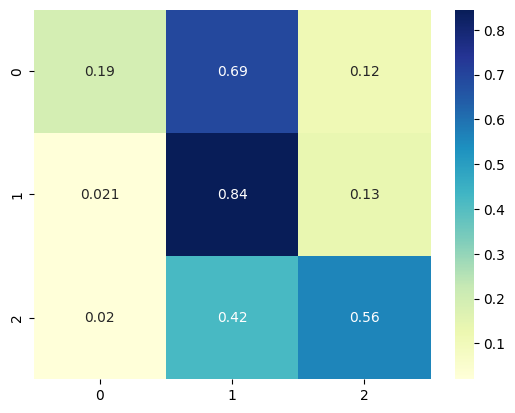

In [45]:
y_tr_pred = random_search_hist_kap.predict(X_train_dogs)
our_metrics(y_train_dogs, y_tr_pred, normalize=True)

# Rebalance classes


In [46]:
#pip install imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


In [91]:
# export processed data set to csv

# export features for tree-based models
X_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_all.csv')
X_test_dogs =pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_all.csv')


# export target
y_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv')
y_test_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv')


In [4]:
import imblearn

In [65]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [76]:
y_train_dogs = [x-1 if x >= 3 else x for x in y_train_dogs.adoptionspeed]
y_test_dogs = [x-1 if x >= 3 else x for x in y_test_dogs.adoptionspeed]

In [87]:
oversample = RandomUnderSampler(sampling_strategy="not minority") # OVERsamples the minority class(es)

In [94]:
print(pd.DataFrame(y_train_dogs).shape,pd.DataFrame(y_train_dogs).value_counts())

(4966, 1) adoptionspeed
4                1401
2                1330
3                1213
1                1022
Name: count, dtype: int64


In [88]:
X_over, y_over = oversample.fit_resample(X_train_dogs, y_train_dogs)

In [89]:
print(pd.DataFrame(y_over).shape,pd.DataFrame(y_over).value_counts())

(4088, 1) adoptionspeed
1                1022
2                1022
3                1022
4                1022
Name: count, dtype: int64


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/janschlautmann/neuefische/ds_capstone_pet_adopta

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4016
_____________________
Weighted Quadratic Kappa: 0.3363


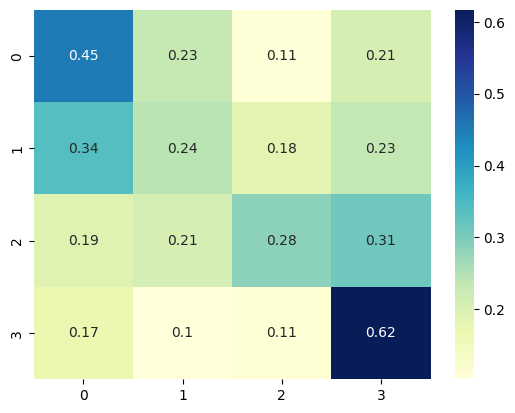

In [93]:
hist_classifier = GradientBoostingClassifier(random_state=42)
param_grid = {
                'loss': ["log_loss","exponential"],
                #'max_iter': [3,5,15,25,50,75,100,150],
                'learning_rate': [0.01,0.05,0.1,0.125,0.15,0.2],
                'max_leaf_nodes': [10,13,15,17,19],
                'max_depth': [15,20,None],
                #'l2_regularization': [0,0.25,0.5,0.75,1],
                'max_features': ['sqrt', 'log2'],
                'subsample': [0.8,0.9,1]
                }

        #kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

random_search_hist_kap = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=100,random_state=42)

random_search_hist_kap.fit(X_over, y_over)

y_pred_rc = random_search_hist_kap.predict(X_test_dogs)
our_metrics(y_test_dogs, y_pred_rc, normalize=True)

# Just 2 classes

In [55]:
y_train_dogs.value_counts()

adoptionspeed
4                1401
2                1330
3                1213
1                1022
Name: count, dtype: int64

In [56]:
# Rerun second code block before starting here
y_train_dogs = y_train_dogs.adoptionspeed.replace(3,2).replace(4,2)
y_test_dogs = y_test_dogs.adoptionspeed.replace(3,2).replace(4,2)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.7941
_____________________
Weighted Quadratic Kappa: 0.0


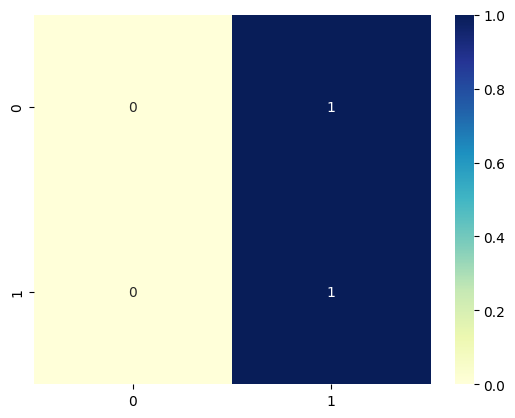

In [57]:
hist_classifier = GradientBoostingClassifier(random_state=42)
param_grid = {
                'loss': ["log_loss"],
                #'max_iter': [3,5,15,25,50,75,100,150],
                'learning_rate': [0.01,0.05,0.1,0.125,0.15,0.2],
                'max_leaf_nodes': [10,13,15,17,19],
                'max_depth': [15,20,None],
                #'l2_regularization': [0,0.25,0.5,0.75,1],
                'max_features': ['sqrt', 'log2'],
                'subsample': [0.8,0.9,1]
                }

        #kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

random_search_hist_kap = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=100,random_state=42)

random_search_hist_kap.fit(X_train_dogs, y_train_dogs)

y_pred_rc = random_search_hist_kap.predict(X_test_dogs)
our_metrics(y_test_dogs, y_pred_rc, normalize=True)

In [54]:
y_pred_rc

array([2, 3, 1, ..., 2, 3, 4])

# Ooopsie. Have to Oversample

In [58]:
oversample = RandomOverSampler(sampling_strategy="not majority")

In [59]:
X_over, y_over = oversample.fit_resample(X_train_dogs, y_train_dogs)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.68
_____________________
Weighted Quadratic Kappa: 0.1902


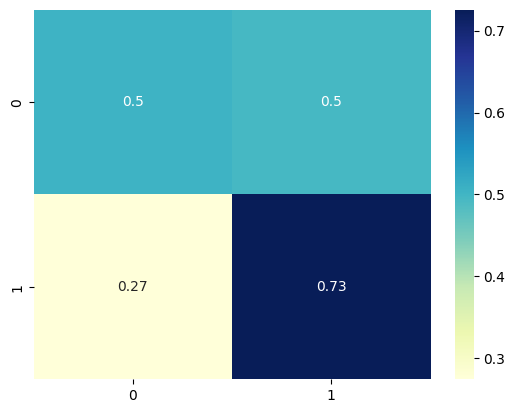

In [61]:
hist_classifier = GradientBoostingClassifier(random_state=42)
param_grid = {
                'loss': ["log_loss"],
                #'max_iter': [3,5,15,25,50,75,100,150],
                'learning_rate': [0.01,0.05,0.1,0.125,0.15,0.2],
                'max_leaf_nodes': [10,13,15,17,19],
                'max_depth': [15,20,None],
                #'l2_regularization': [0,0.25,0.5,0.75,1],
                'max_features': ['sqrt', 'log2'],
                'subsample': [0.8,0.9,1]
                }

        #kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

random_search_hist_kap = RandomizedSearchCV(hist_classifier, param_grid, scoring="accuracy", cv=5, n_jobs=-1,n_iter=100,random_state=42)

random_search_hist_kap.fit(X_over, y_over)

y_pred_rc = random_search_hist_kap.predict(X_test_dogs)
our_metrics(y_test_dogs, y_pred_rc, normalize=True)

# Single best model




/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4197
_____________________
Weighted Quadratic Kappa: 0.3493


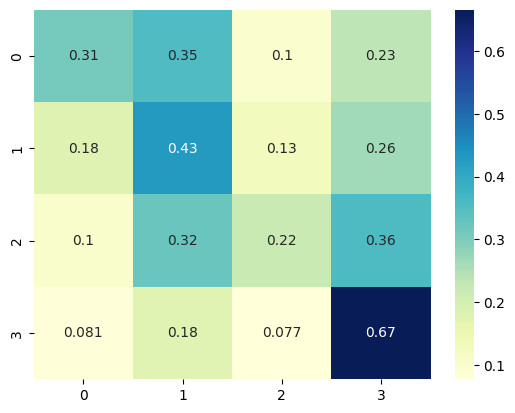

In [5]:
best = GradientBoostingClassifier(random_state=42,subsample=0.9, max_leaf_nodes= 10, max_features= 'sqrt', max_depth = 15, loss = 'log_loss', learning_rate= 0.1)
best.fit(X_train_dogs,y_train_dogs)
y_best_pred = best.predict(X_test_dogs)
our_metrics(y_test_dogs,y_best_pred,normalize=True)

In [106]:
# export processed data set to csv

# export features for tree-based models
X_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_dropped.csv')
X_test_dogs =pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_dropped.csv')


# export target
y_train_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv')
y_test_dogs = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv')


/Users/janschlautmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4197
_____________________
Weighted Quadratic Kappa: 0.3493


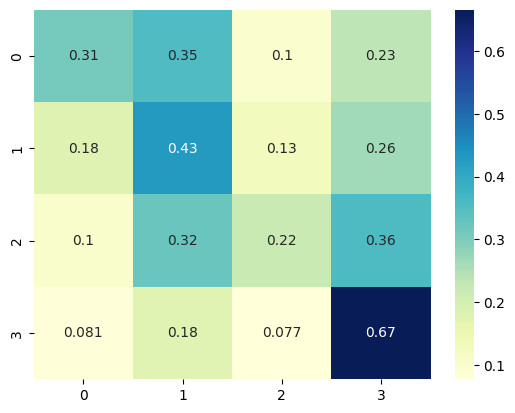

In [9]:
best = GradientBoostingClassifier(random_state=42,subsample=0.9, max_leaf_nodes= 10, max_features= 'sqrt', max_depth = 15, loss = 'log_loss', learning_rate= 0.1)
best.fit(X_train_dogs,y_train_dogs)
y_best_pred = best.predict(X_test_dogs)
our_metrics(y_test_dogs,y_best_pred,normalize=True)

In [11]:
fi = pd.DataFrame(best.feature_importances_.tolist(),index=X_train_dogs.columns.to_list())
